<div id="c-s-hlist">
    <ul>
        <li><a href="#intro">Intro</a></li>
        <li><a href="#setting-game-env">Setting up the game environment</a></li>
        <li><a href="#play-a-game-manually">Play a game manually</a></li>
        <li><a href="#play-a-game-auto">Play a game auto</a></li>
        <li><a href="#simulation">Simulation</a></li>
        <li><a href="#closing-words">Closing words</a></li>
    </ul>
</div>

<h2 id='intro'> Intro </h2>

&emsp; This challenge, we will make auto pick and drop game that agent can auto reach a goal that can pick up item from pick up point and then go to drop-off point for drop the item then game will ending. So agent will learning to play with reinforcement learning, that this cahllenge we will compare 2 policy that is <u>Naive Random Solution</u> or <u>random walk solution</u> and <u>Q-learning algorithm</u>.

<h2 id="setting-game-env"> Setting up the game environment </h2>

&emsp; The Pick and Drop Game environment are contain a field boundary and rules. field are boundary in widht * height and the rules of game are:
- If the agent tries to go off the field, punish with -10 in reward.
- If the agent makes a (legal) move, punish with -1 in reward, as we do not want to encourage endless walking around.
- If the agent tries to pick up item, but it is not there or it has it already, punish with -10 in reward.
- If the agent picks up the item correct place, reward with 20.
- If agent tries to drop-off item in wrong place or does not have the item, punish with -10 in reward.
- If the agent drops-off item in correct place, reward with 20.

In [1]:
class Field:
    def __init__(self, size, item_pickup, item_dropoff, start_position):
        self.size = size  # Size of the board
        self.item_pickup = item_pickup
        self.item_dropoff = item_dropoff
        self.position = start_position
        self.item_in_car = False
    
    def get_number_of_states(self):
        # All possible state
        # We have m row * n column
        #   So posibility of picked-up = m*n
        #   Meanwhile posibility of drop-off = m*n
        #   And last check the agent have carry item or not = *2
        return self.size * self.size * self.size * self.size * 2
    
    def get_state(self):
        # Calculate Manhattan distances to goals
        dist_to_pickup = abs(self.position[0] - self.item_pickup[0]) + abs(self.position[1] - self.item_pickup[1])
        dist_to_dropoff = abs(self.position[0] - self.item_dropoff[0]) + abs(self.position[1] - self.item_dropoff[1])
        
        # Base state from position
        state = self.position[0] * self.size + self.position[1]
        
        # Add carrying state (if the item is in the car, add an offset)
        if self.item_in_car:
            state = state + (self.size * self.size)
        
        # Add distance to goals (pickup or dropoff)
        if not self.item_in_car:
            state = state * self.size + dist_to_pickup
        else:
            state = state * self.size + dist_to_dropoff
        
        return state
    
    def make_action(self, action):
        (x, y) = self.position
        
        # Actions and their corresponding rewards
        if action == 0:  # Move down
            if y == self.size - 1:
                return -10, False
            else:
                self.position = (x, y + 1)
                return -1, False
        elif action == 1:  # Move up
            if y == 0:
                return -10, False
            else:
                self.position = (x, y - 1)
                return -1, False
        elif action == 2:  # Move left
            if x == 0:
                return -10, False
            else:
                self.position = (x - 1, y)
                return -1, False
        elif action == 3:  # Move right
            if x == self.size - 1:
                return -10, False
            else:
                self.position = (x + 1, y)
                return -1, False
        elif action == 4:  # Pick-up
            if self.item_in_car or self.item_pickup != (x, y):
                return -10, False
            else:
                self.item_in_car = True
                return 20, False
        elif action == 5:  # Drop-off
            if not self.item_in_car or self.item_dropoff != (x, y):
                return -10, False
            else:
                self.item_in_car = False
                return 20, True

<h2 id='play-a-game-manually'> Play a game manually </h2>

&emsp; We can test a rule with manual playing to make sure coding is following the rules.

In [2]:
size = 10  # Size of field
item_pickup = (0,0)  # Coordinate place to pick up the items
item_dropoff = (9,9) # Coordinate place to drop item off
start_position = (9,0)  # Coodinale place to starting game and agent will start here

# Initializing a game
field = Field(size, item_pickup, item_dropoff, start_position)

To check a place of strating position of agent.

In [3]:
field.position

(9, 0)

Moving up 1 step.

In [4]:
field.make_action(1)

(-10, False)

-So, these rules are working correctly and going back down to the starting place.

In [5]:
field.make_action(0)

(-1, False)

Moving along the left until we go to the pickup place.

In [6]:
field.make_action(2)
field.make_action(2)
field.make_action(2)
field.make_action(2)
field.make_action(2)
field.make_action(2)
field.make_action(2)
field.make_action(2)
field.make_action(2)

(-1, False)

To pick up the item.

In [7]:
field.make_action(4)

(-10, False)

Moving down until meet a field boundary.

In [8]:
field.make_action(0)
field.make_action(0)
field.make_action(0)
field.make_action(0)
field.make_action(0)
field.make_action(0)
field.make_action(0)
field.make_action(0)
field.make_action(0)

(-10, False)

Moving along the right until we go to the dop-off place.

In [9]:
field.make_action(3)
field.make_action(3)
field.make_action(3)
field.make_action(3)
field.make_action(3)
field.make_action(3)
field.make_action(3)
field.make_action(3)
field.make_action(3)

(-1, False)

Dropping the carrying item, then the game will end.

In [10]:
field.make_action(5)

(-10, False)

So this game is not a problem occurring.

<h2 id='play-a-game-auto'> Play a game auto </h2>

In [11]:
size = 5
item_pickup = (1, 1)
item_dropoff = (4, 4)
start_position = (0, 0)

# Initializing a game
field = Field(size, item_pickup, item_dropoff, start_position)

- ### Naive Random or random walk plan
<br>&emsp;&emsp; - It's the most basic approach to reinforcement learning (RL).
<br>&emsp;&emsp; - The agent selects actions randomly, without considering past experiences or rewards.
<br>&emsp;&emsp; - It's often used as a baseline to compare against more sophisticated RL algorithms.
<br>&emsp;&emsp; - No learning: The agent doesn't learn from its actions or outcomes.
<br>&emsp;&emsp; - No strategy: There's no intentional planning or decision-making involved. Uncertain performance: Results can vary greatly depending on chance

In [12]:
import random

def random_plan(field):
    done = False
    steps = 0
    
    while not done:
        action = random.randint(0,5)
        reward, done = field.make_action(action)
        steps = steps + 1

    return steps

A steps from running with 1 episode

In [13]:
random_plan(field)

630

Average runing step from 100 episodes

In [14]:
run = [random_plan(field) for _ in range(100)]
sum(run)/len(run)

554.45

- ### Q-Learning algorithm plan

&emsp; This algorithm used to find the optimal policy for an agent interacting with an environment. It learns by updating a Q-value table that estimates the expected future rewards for taking certain actions in specific states.

<u>The step of each iteration of Q-table are:</u>
<br>&emsp;&emsp; - Initialise the Q-table with all values set to 0
<br>&emsp;&emsp; - Set hyperparameters:
<br>&emsp;&emsp;&emsp;&emsp; - Alpha (α) or learning rate: α is a numerical value between 0 and 1. Higher values of α indicate that the agent cares more about previous experience, while lower values indicate a low effect of previous experience impact to new experience.
<br>&emsp;&emsp;&emsp;&emsp; - Gamma (γ) or discount factor: γ is a numerical value between 0 and 1. γ is basically allows you to add a penalty on later step. Higher values of γ indicate that the agent cares more about future rewards, while lower values indicate a preference for immediate pleasure or satisfaction.
<br>&emsp;&emsp;&emsp;&emsp; - Epsilon (ε) or exploration rate: ε is a numerical value between 0 and 1. Represents the probability of taking a random action. Higher ε values mean more exploration, while lower values mean more exploitation (focusing on known optimal actions). 
<br>&emsp;&emsp; - Iteration
<br>&emsp;&emsp;&emsp;&emsp; - With probability epsilon choose to explore, else exploit.
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; - If explore, then choose a random action.
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; - If exploit, then choose the best action based on the current Q-table.
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; - Update the Q-table from the new reward to the previous state.
<center>Q[state, action] = (1 - alpha) * Q[state, action] + alpha * (reward + gamma * max(Q[new_state]) - Q[state, action])</center>

<br>A one important hyperparameter to to set before runnig a Q-table are number of episodes that each episode are 2 possible that is can drop the item and reach max step with can not drop the item. We can not say what a certain value that optimal number of episodes. But we can roughly optimize that where q-table is converged (the last value of q-table of last episode is same or almost same average of for example last 5 episode). So if q-table is converged
Will tell us should stop episode number at here. So this mean knowing new thing that not change or can say that thing same as previous know.

In [15]:
import numpy as np

#                             alpha    ,       gamma         ,          epsilon
def q_learning(field, learning_rate=0.1, discount_factor=0.9, exploration_rate=0.1, max_steps=1000):
    size = field.size
    num_states = field.get_number_of_states()
    q_table = np.zeros((num_states, 6))  # 6 possible actions

    def select_action(state):
        if np.random.rand() < exploration_rate:
            return np.random.choice(6)  # Explore: choose a random action
        else:
            return np.argmax(q_table[state, :])  # Exploit: choose the action with the highest Q-value

    def update_q_table(state, action, reward, next_state):
        best_next_action = np.argmax(q_table[next_state, :])
        q_table[state, action] += learning_rate * (reward + discount_factor * q_table[next_state, best_next_action] - q_table[state, action])

    state = field.get_state()
    steps = 0

    for _ in range(max_steps):
        action = select_action(state)
        reward, done = field.make_action(action)

        steps += 1

        next_state = field.get_state()
        update_q_table(state, action, reward, next_state)

        state = next_state

        if done:
            return steps

    return max_steps  # Return max_steps if the goal is not reached within the specified maximum step

When compare <u>random walk plan</u> with <u>Q-Learning algorithm plan</u> in all step. <u>Q-Learning algorithm plan</u> will be more efficient than <u>random walk plan</u> in almost case, but still need <u>random walk plan</u> for base comparision and can guide something like max_step of running in q-learning.

- A max_step from trial.

In [16]:
# hyperpameter
learning_rate=0.01
discount_factor=0.5
exploration_rate=0.1
max_steps= 100
num_episodes = 100

# Tracking parameter
total_steps = 0
fail = 0
success = 0

# learning with episode
for episode in range(num_episodes):
    steps = q_learning(field, learning_rate, discount_factor, exploration_rate, max_steps)
    total_steps += steps
    if steps < max_steps:
        success += 1
    else:
        fail += 1
        
sp = success/num_episodes
fp = fail/num_episodes

print(f"percentage of successed to archive a target: {sp:2f}")
print(f"percentage of fail to archive a target: {fp:2f}")
average_steps = total_steps / num_episodes
print(f"Average Steps to Goal over {num_episodes} episodes: \nTotal step {total_steps} \nAverage  step {average_steps}")

percentage of successed to archive a target: 0.100000
percentage of fail to archive a target: 0.900000
Average Steps to Goal over 100 episodes: 
Total step 9621 
Average  step 96.21


- A max_step that consider from random plan.

In [17]:
# hyperpameter
learning_rate=0.01
discount_factor=0.5
exploration_rate=0.1
max_steps= 600
num_episodes = 100

# Tracking parameter
total_steps = 0
fail = 0
success = 0

# learning with episode
for episode in range(num_episodes):
    steps = q_learning(field, learning_rate, discount_factor, exploration_rate, max_steps)
    total_steps += steps
    if steps < max_steps:
        success += 1
    else:
        fail += 1
        
sp = success/num_episodes
fp = fail/num_episodes

print(f"percentage of successed to archive a target: {sp:2f}")
print(f"percentage of fail to archive a target: {fp:2f}")
average_steps = total_steps / num_episodes
print(f"Average Steps to Goal over {num_episodes} episodes: \nTotal step {total_steps} \nAverage  step {average_steps}")

percentage of successed to archive a target: 1.000000
percentage of fail to archive a target: 0.000000
Average Steps to Goal over 100 episodes: 
Total step 35827 
Average  step 358.27


&emsp; So, my second trial are estimate max_steps from average runing from <u>random walk plan</u>, this can improve the agent's learning and can help it reach its target in all episodes. But the step seems too high, and we are not sure this is the optimal episode number for training the agent. Then optimal solutions are Q-learning algorithms with converging Q-table plans. That can detect a convergence value of the Q-table to detect knowing a new thing that has not changed.

- ### Q-learning algorithm with convergence Q-table plan

In [18]:
import numpy as np
from tabulate import tabulate

def q_learning_with_convergence(field, learning_rate=0.1, discount_factor=0.9, 
                                exploration_rate=0.1, max_steps=1000, max_episodes=10000,
                                convergence_threshold=0.01, window_size=100):
    size = field.size
    num_states = field.get_number_of_states()
    q_table = np.zeros((num_states, 6))  # 6 possible actions (4 move + 2 pick/drop)
    
    # Track Q-value changes
    q_value_history = []
    avg_q_changes = []
    
    def select_action(state):
        if np.random.rand() < exploration_rate:
            return np.random.choice(6)  # Random exploration
        else:
            return np.argmax(q_table[state])  # Exploit learned values
    
    def update_q_table(state, action, reward, next_state):
        old_q = q_table[state, action]
        best_next_action = np.argmax(q_table[next_state])  # Max Q for the next state
        q_table[state, action] += learning_rate * (
            reward + discount_factor * q_table[next_state, best_next_action] - old_q
        )
        return abs(old_q - q_table[state, action])
    
    episode_steps = []
    convergence_reached = False
    episode = 0
    
    # Main loop for running episodes until convergence is reached or max episodes are completed
    while not convergence_reached and episode < max_episodes:
        state = field.get_state()
        steps = 0
        q_changes = []
        
        for _ in range(max_steps):
            # Action and reward
            action = select_action(state)
            reward, done = field.make_action(action)
            next_state = field.get_state()
            
            # Track Q-value change
            q_change = update_q_table(state, action, reward, next_state)
            q_changes.append(q_change)
            
            steps += 1
            state = next_state
            
            if done:
                break
        
        # Append changed history
        episode_steps.append(steps)
        avg_q_change = np.mean(q_changes)
        q_value_history.append(avg_q_change)
        
        # Check for convergence
        if len(q_value_history) >= window_size:
            avg_change = np.mean(q_value_history[-window_size:])
            avg_q_changes.append(avg_change)
            
            # If changed history reach to convergence threshold
            if avg_change < convergence_threshold:
                convergence_reached = True
                print(f"Convergence reached after {episode + 1} episodes")
                print(f"Average steps in last {window_size} episodes: {np.mean(episode_steps[-window_size:]):.2f}")
                print(f"Final average Q-value change: {q_value_history[-1]:.6f}")
                break
        
        episode += 1
    
    return {
        'episodes_needed': episode + 1,
        'q_table': q_table,
        'episode_steps': episode_steps,
        'q_value_history': q_value_history,
        'avg_q_changes': avg_q_changes
    }

The `window_size` parameter defines the number of recent episodes to consider when checking for convergence. The function calculates the average Q-value change over this window of episodes to determine if the Q-values have stabilized with detection by `convergence_threshold`. Hyperparameters need to be tuned also for optimal learning for the agent. But now try to use the default parameter.

In [19]:
filed_size = 5

# Set up the field
field = Field(
    size=filed_size,
    item_pickup=(0, 0),
    item_dropoff=(4, 4),
    start_position=(2, 2)
)

# learning model
model = q_learning_with_convergence(field)

Convergence reached after 1593 episodes
Average steps in last 100 episodes: 20.09
Final average Q-value change: 0.000000


It seems too good at initial hyperparameter setting by default. Then save and load the model to make the agent auto-decision-making by specifying episodes as we want.

- ### Save a Model

In [20]:
import pickle

# Save the model to a file
with open("q_learning_pick_and_drop.pkl", "wb") as model_file:
    pickle.dump(model, model_file)

print("Model saved successfully as 'q_learning_model.pkl'")

Model saved successfully as 'q_learning_model.pkl'


<h2 id='simulation'> Simulation </h2>

- ### Load a Model

In [21]:
# Load the model from a file
with open("q_learning_pick_and_drop.pkl", "rb") as model_file:
    results = pickle.load(model_file)

print("Model loaded successfully.")

Model loaded successfully.


- ### Agent auto play

In [22]:
import pygame
import time
import random

class GameVisualizer:
    def __init__(self, training_field, q_table, cell_size=100):
        
        # Initializing pygame
        pygame.init()
        
        # Game environment and window screen setting
        self.size = training_field.size
        self.item_pickup = training_field.item_pickup
        self.item_dropoff = training_field.item_dropoff
        self.q_table = q_table
        self.cell_size = cell_size
        self.width = self.size * cell_size + 300  # Extra width for stats
        self.height = self.size * cell_size  
        self.screen = pygame.display.set_mode((self.width, self.height))
        pygame.display.set_caption("Q-Learning Agent")
        self.font = pygame.font.Font(None, 30)
        self.small_font = pygame.font.Font(None, 24)
        
        # Colors setting
        self.WHITE = (255, 255, 255)
        self.BLACK = (0, 0, 0)
        self.RED = (255, 0, 0)
        self.GREEN = (0, 255, 0)
        self.BLUE = (0, 0, 255)

    def create_visualization_field(self, start_position):
        # Create a game environment
        return Field(
            size=self.size,
            item_pickup=self.item_pickup,
            item_dropoff=self.item_dropoff,
            start_position=start_position
        )

    def draw_grid(self):
        # Drawing a game field
        for x in range(self.size):
            for y in range(self.size):
                rect = pygame.Rect(x * self.cell_size, y * self.cell_size, 
                                   self.cell_size, self.cell_size)
                pygame.draw.rect(self.screen, self.BLACK, rect, 1)

    def draw_state(self, field):
        # Drawing a pickup, dropoff and agent position on a field
        px, py = field.item_pickup
        pickup_rect = pygame.Rect(px * self.cell_size, py * self.cell_size, 
                                  self.cell_size, self.cell_size)
        pygame.draw.rect(self.screen, self.GREEN, pickup_rect)
        
        dx, dy = field.item_dropoff
        dropoff_rect = pygame.Rect(dx * self.cell_size, dy * self.cell_size, 
                                   self.cell_size, self.cell_size)
        pygame.draw.rect(self.screen, self.RED, dropoff_rect)
        
        x, y = field.position
        agent_radius = self.cell_size // 3
        agent_center = (x * self.cell_size + self.cell_size // 2, 
                       y * self.cell_size + self.cell_size // 2)
        color = self.BLUE if field.item_in_car else self.BLACK
        pygame.draw.circle(self.screen, color, agent_center, agent_radius)

    def draw_stats(self, field, action, episode, step, max_episodes, max_steps, total_steps):
        # Drawing a stats albel 
        
        # Episode and step
        episode_text = f"Episode: {episode}/{max_episodes}"
        step_text = f"Step: {step}/{max_steps}"
        episode_surface = self.font.render(episode_text, True, self.BLACK)
        step_surface = self.font.render(step_text, True, self.BLACK)
        self.screen.blit(episode_surface, (self.width - 280, 15))
        self.screen.blit(step_surface, (self.width - 280, 45))

        # Pickup and dropoff locations
        pickup_text = "Green: Pickup Point"
        dropoff_text = "Red: Dropoff Point"
        pickup_surface = self.font.render(pickup_text, True, self.GREEN)
        dropoff_surface = self.font.render(dropoff_text, True, self.RED)
        self.screen.blit(pickup_surface, (self.width - 280, 75))
        self.screen.blit(dropoff_surface, (self.width - 280, 105))

        # Current position
        position_text = f"Current Position: {field.position}"
        position_surface = self.font.render(position_text, True, self.BLACK)
        self.screen.blit(position_surface, (self.width - 280, 135))

        # Action
        action_text = f"Action: {action}"
        action_surface = self.font.render(action_text, True, self.BLACK)
        self.screen.blit(action_surface, (self.width - 280, 165))

        # Carrying item
        carrying_text = f"Carrying Item: {'Yes' if field.item_in_car else 'No'}"
        carrying_surface = self.font.render(carrying_text, True, self.BLACK)
        self.screen.blit(carrying_surface, (self.width - 280, 195))

        # Q-table values
        q_table_values_text = "Q-Table Values:"
        q_table_values_surface = self.font.render(q_table_values_text, True, self.BLACK)
        self.screen.blit(q_table_values_surface, (self.width - 280, 225))
        
        # Action state of Q-table values
        state = field.get_state()
        for i, value in enumerate(self.q_table[state]):
            q_value_text = f"• Action {i}: {value:.2f}"
            q_value_surface = self.small_font.render(q_value_text, True, self.BLACK)
            self.screen.blit(q_value_surface, (self.width - 250, 255 + i * 30))

        # Average steps 
        average_steps_text = f"Average Steps: {total_steps / episode:.2f}" if episode > 0 else "Average Steps: N/A"
        average_steps_surface = self.font.render(average_steps_text, True, self.BLACK)
        self.screen.blit(average_steps_surface, (self.width - 280, 255 + len(self.q_table[state]) * 30 + 30))


    def get_best_action(self, field):
        # Get best action to let's agent decision-making
        state = field.get_state()
        return np.argmax(self.q_table[state])

    def cleanup(self):
        # Close pygame
        pygame.quit()


pygame 2.6.1 (SDL 2.28.4, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [23]:
import pygame
from IPython.display import display, Image
import io
from PIL import Image as PILImage

def visualize_agent(training_field, results, start_position=None, max_episodes=100, max_steps=1000):
    # Parameter Setting
    visualizer = GameVisualizer(training_field, results['q_table'])
    running = True
    clock = pygame.time.Clock()

    current_episode = 1
    current_step = 0
    total_steps = 0
    success_message = ""
    success_color = visualizer.BLACK  # Default color
    
    frames = []

    try:
        # Runing with episode
        while running and current_episode <= max_episodes:
            # Randomize starting position if not provided
            if start_position is None:
                x = random.randint(0, training_field.size - 1)
                y = random.randint(0, training_field.size - 1)
                episode_start_position = (x, y)
            else:
                episode_start_position = start_position

            # Initialize field for the current episode
            field = visualizer.create_visualization_field(episode_start_position)
            success_message = ""

            # Running with max step
            while running and current_step < max_steps:
                for event in pygame.event.get():
                    # Close a winfow, if click close button on top right of window
                    if event.type == pygame.QUIT:
                        running = False
                        break
                        
                    # If a not reach a goal (droped an item) press "R" button for go back to starting point
                    if event.type == pygame.KEYDOWN:
                        if event.key == pygame.K_r:
                            field = visualizer.create_visualization_field(episode_start_position)
                            current_step = 0

                if not running:
                    break

                # Clear screen and draw UI
                visualizer.screen.fill(visualizer.WHITE)
                visualizer.draw_grid()
                action = visualizer.get_best_action(field)
                visualizer.draw_state(field)
                visualizer.draw_stats(field, action, current_episode, current_step, max_episodes, max_steps, total_steps)
                pygame.display.flip()

                # Save the pygame surface (window) as an image
                buffer = io.BytesIO()
                pygame.image.save(visualizer.screen, buffer)
                buffer.seek(0)
                frame = PILImage.open(buffer).convert("RGB")
                frames.append(frame)

                # Determine the best action and make the move
                reward, done = field.make_action(action)
                current_step += 1
                
                # If agent can achieve a target (droped an item)
                if done:
                    if reward > 0:
                        success_message = "Success!"
                        success_color = (0, 255, 0)  # Green
                    break
                    
                # If agent fail to achieve a target ( reach to max step but can not droped an item
                if current_step == max_steps:
                    success_message = "Fail!"
                    success_color = (255, 0, 0)  # Red
                
                # Control the frame rate (2 frames per second)
                clock.tick(2)

            # Show success or failure message for 1 second
            visualizer.screen.fill(visualizer.WHITE)
            visualizer.draw_grid()
            action = visualizer.get_best_action(field)
            visualizer.draw_state(field)
            visualizer.draw_stats(field, action, current_episode, current_step, max_episodes, max_steps, total_steps)
            if success_message:
                large_font = pygame.font.SysFont(None, 72)  # Large font size
                text_surface = large_font.render(success_message, True, success_color)
                                                              # -150 from extra space and need to center of grid                                      
                text_rect = text_surface.get_rect(center=( (visualizer.width / 2)-150, visualizer.height / 2))
                visualizer.screen.blit(text_surface, text_rect)
                pygame.display.flip()
                
                # Save the pygame surface with the message as an image
                buffer = io.BytesIO()
                pygame.image.save(visualizer.screen, buffer)
                buffer.seek(0)
                frame = PILImage.open(buffer).convert("RGB")
                frames.append(frame)

                time.sleep(1)

            total_steps += current_step
            current_episode += 1
            current_step = 0

    finally:
        visualizer.cleanup()
        
        # Save the frames as a GIF and display a GIF as output
        if frames:
            # Save a gif
            frames[0].save("agent-visualization.gif", save_all=True, append_images=frames[1:], duration=500, loop=0)
            
            # Load a gif
            with open("agent-visualization.gif", "rb") as f:
                display(Image(f.read(), format='png'))

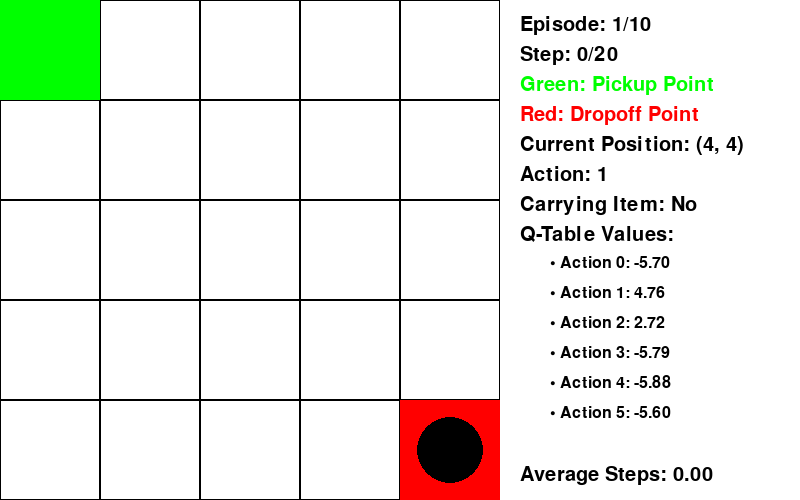

In [24]:
# visualize learning result with random starting a postion

visualize_agent(field, results, max_episodes=10, max_steps=20)

&emsp; So, when we make the agent autoplay with 10 episodes, and each episode is a different starting point, the agent can achieve a goal in all episodes even when we train with `model = q_learning_with_convergence(field)` and `field` is `start_position=(2, 2)`. This means the agent is learning properly with optimal process and hyperparameter setting, and estimation of average step in all episodes is 13 episodes that are a step closer and not over to average steps in the last 100 episodes: 20.09 in the training model.

<br> A stats on the right showing in episode how the agent is making an action on each action state, the action state on the Q-table value showing a reward when the agent is making an action. So, this is how an agent can learn and make a decision.

<h2 id='closing-words'> Closing words </h2>

&emsp; So, This challenge demonstrates the implementation of the Q-learning algorithm and agent visualization, illustrating how an agent learns and takes actions based on rewards influenced by its environment. Q-learning is just one approach within the broader category of reinforcement learning algorithms; there are other methods available for enabling agents to learn effectively.

&emsp; If you found this challenge helpful, feel free to share it. Don’t forget to check out my other projects for more coding inspiration. Enjoy reading!